# Sentiment Analysis on Reviews of Amazon's Alexa

* Neural networks predicting if a review for Amazon's Alexa is positive or negative;
* Data extracted from Amazon's website;
* Dataset with 3150 reviews for product purchases of Amazon's Alexa;
* Data is processed without changing class imbalance or performing data augmentation;
* First prediction based on review comments, rating and product variation;
* Second prediction based only on review comments and product variation;
* A binarized bag of words is created from review comments to feed a shallow fully-connected neural network;
* Results evaluated using area under ROC (Receiver Operating Characteristic) and PR (Precision-Recall) curves;
* Dataset online version: https://www.kaggle.com/datasets/sid321axn/amazon-alexa-reviews

In [ ]:
import re

import nltk
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import (confusion_matrix,
                             roc_auc_score,
                             average_precision_score)

## Data Exploration

In this notebook, we create a classifier that performs sentiment analysis to preview if the feedback from someone purchasing an Amazon's Alexa is positive or negative.

Our dataset is in a .tsv file, meaning that it uses the "tab" character as a separator. After loading it using Pandas, we can print it to see its overall appearance.

"rating" column refers to how many stars the reviewer gave to the product, from 1 to 5. "date" is the date of review. "variation" is the Alexa product model associated with the review. "verified_reviews" is the textual comment provided by the reviewer.

Pandas dataframe's `info` method can tell us if there are null values in the data if we check the count for non-null values. Should be 3150 for all columns, since this is a dataset with 3150 instances. Other than that, we can see that the dataset is small, with only 123 KB of memory usage, so we do not need to worry about resource constraints.

In [ ]:
alexa_df = pd.read_csv('../data/raw/amazon-alexa.tsv', delimiter='\t')
alexa_df

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1
...,...,...,...,...,...
3145,5,30-Jul-18,Black Dot,"Perfect for kids, adults and everyone in betwe...",1
3146,5,30-Jul-18,Black Dot,"Listening to music, searching locations, check...",1
3147,5,30-Jul-18,Black Dot,"I do love these things, i have them running my...",1
3148,5,30-Jul-18,White Dot,Only complaint I have is that the sound qualit...,1


In [ ]:
alexa_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   rating            3150 non-null   int64 
 1   date              3150 non-null   object
 2   variation         3150 non-null   object
 3   verified_reviews  3150 non-null   object
 4   feedback          3150 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 123.2+ KB


If we check for data imbalance in this dataset, we see that the two classes (positive and negative review) are very imbalanced. Looking at count plots for both "feedback" and "rating" columns, we conclude that there are much more positive than negative reviews.

Typically, it would be interesting to try to balance the classes by performing resampling or data augmentation. However, we have to take into account that product reviews on the internet tend to be very positive. Buyers are not afraid of giving 5 stars in a review if the product just fulfils their minimal expectations.

We want to build a model that is really able to understand buyers behaviors, even the excess of positive reviews. Because of that, and also given the fact that imbalance treatment depends on fake data generation, we try to stick with the original instances and see the results.

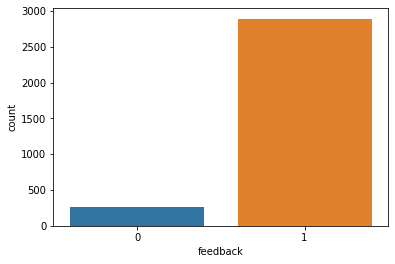

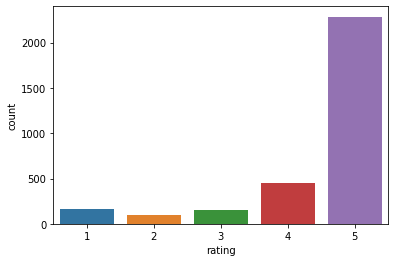

In [ ]:
alexa_df_positive = alexa_df[alexa_df['feedback'] == 1]
alexa_df_negative = alexa_df[alexa_df['feedback'] == 0]

sns.countplot(x=alexa_df['feedback'], label='count')
plt.show()

sns.countplot(x=alexa_df['rating'], label='count')
plt.show()

## Data Preprocessing

For our first evaluation, we want to use the "rating" column. This is supposed to be an easier task for our model since, intuitively, a product rating is highly correlated with the feedback.

We will make our dataset a full binary bag of words, meaning that product variations and ratings will be one-hot encoded.

Technically, the rating variable could be treated as a discrete numerical variable, instead of a categorical one, but we aim to build a language processing model. Ratings are treated as terms in our bag of words.

Column "date" is discarded as it is not relevant for our prediction.

In [ ]:
alexa_variation_onehot = pd.get_dummies(alexa_df['variation'])
alexa_rating_onehot = pd.get_dummies(alexa_df['rating'])
alexa_rating_onehot.columns = ['1 Star', '2 Stars', '3 Stars', '4 Stars',
                               '5 Stars']

alexa_onehot = pd.concat((alexa_variation_onehot, alexa_rating_onehot), axis=1)
alexa_onehot

,Black,Black Dot,Black Plus,Black Show,Black Spot,Charcoal Fabric,Configuration: Fire TV Stick,Heather Gray Fabric,Oak Finish,Sandstone Fabric,...,White,White Dot,White Plus,White Show,White Spot,1 Star,2 Stars,3 Stars,4 Stars,5 Stars
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3145,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3146,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3147,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3148,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1


In [ ]:
alexa_df.drop(['rating', 'date', 'variation'], axis=1, inplace=True)
alexa_df = pd.concat((alexa_onehot, alexa_df), axis=1)
alexa_df

,Black,Black Dot,Black Plus,Black Show,Black Spot,Charcoal Fabric,Configuration: Fire TV Stick,Heather Gray Fabric,Oak Finish,Sandstone Fabric,...,White Plus,White Show,White Spot,1 Star,2 Stars,3 Stars,4 Stars,5 Stars,verified_reviews,feedback
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,Love my Echo!,1
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,Loved it!,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,"Sometimes while playing a game, you can answer...",1
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,I have had a lot of fun with this thing. My 4 ...,1
4,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,Music,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3145,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,"Perfect for kids, adults and everyone in betwe...",1
3146,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,"Listening to music, searching locations, check...",1
3147,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,"I do love these things, i have them running my...",1
3148,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,Only complaint I have is that the sound qualit...,1


Before we create a bag of words using the review comments, we need to first remove some invalid reviews. Reviews with 2 or less characters and reviews composed of numbers only are considered invalid.

Additionally, we remove stop words from the comments, aiming to eliminate useless terms that would just provide noise to our model. In the end, the reviews provide 3800 unique terms.

In [ ]:
# Substitute reviews with 1 or 2 characters for empty reviews that will
# be interpreted as stop words and removed.
alexa_df['verified_reviews'] = [re.sub(r'\b\w{1,2}\b', '', review) 
                                for review
                                in alexa_df['verified_reviews']]

# Although not perfect, NLTK's stop words are good enough for simple
# comments.
nltk.download('stopwords')
en_stopwords = nltk.corpus.stopwords.words('english')

vectorizer = CountVectorizer(stop_words=en_stopwords)
reviews_tokens = vectorizer.fit_transform(alexa_df['verified_reviews'])
print(reviews_tokens.shape)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


(3150, 3800)


In [ ]:
alexa_df.drop('verified_reviews', axis=1, inplace=True)

reviews = pd.DataFrame(reviews_tokens.toarray(),
                       columns=vectorizer.get_feature_names_out())

# Remove columns that come from numerical only or very short strings of
# any characters.
stop_word_columns = [word
                     for word
                     in reviews.columns
                     if len(word) < 3
                     or re.match(r'^[0-9]+$', word)]
reviews.drop(stop_word_columns, axis=1, inplace=True)

alexa_df = pd.concat((reviews, alexa_df), axis=1)
alexa_df

,100x,1100sf,12am,1gb,1rst,1st,2nd,2package,30pm,3rd,...,White Dot,White Plus,White Show,White Spot,1 Star,2 Stars,3 Stars,4 Stars,5 Stars,feedback
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3145,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
3146,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
3147,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
3148,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,1


Lastly, we split our data in train and test sets having 85% and 15% of the total amount of instances, respectively. Note that for the 85% training instances, 15% are used for validation.

In [ ]:
X = alexa_df.iloc[:, :-1].values
y = alexa_df.iloc[:, -1].values

# random_state is set to help with reproducibility.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15,
                                                    random_state=42)

## Model Building and Training

Our first model is a shallow fully-connected neural network with only 3 layers. All layers used ReLU as activation function, except for the last one, which uses sigmoid. Sigmoid is necessary because this is a binary classification task.

Number of neurons in the first layer is set to be a large amount that does not generate overfitting. The second layer has half the number of neurons in the first layer. Last layer has only 1 neuron because this is a binary classification task.

In [ ]:
nlp_nn_model = tf.keras.models.Sequential()
nlp_nn_model.add(tf.keras.layers.Dense(units=50, activation='relu',
                                       input_shape=(X_train.shape[1],)))
nlp_nn_model.add(tf.keras.layers.Dense(units=25, activation='relu'))
nlp_nn_model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

nlp_nn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                190300    
                                                                 
 dense_1 (Dense)             (None, 25)                1275      
                                                                 
 dense_2 (Dense)             (None, 1)                 26        
                                                                 
Total params: 191,601
Trainable params: 191,601
Non-trainable params: 0
_________________________________________________________________


An early stopping callback is created to help with training. It monitors accuracy in the validation set and has patience set to 5. All training parameters were tuned during the validation process. Comments in code provide additional details on training settings.

In [ ]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', patience=5
)

# 20 batches are used in a data-driven approach.
batch_size = X_train.shape[0] // 20

# Learning rate larger than 0.001 leads to underfitting.
nlp_nn_model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001),
                     loss='binary_crossentropy', metrics=['accuracy'])

# 100 epochs are enough to let the early stopping callback work.
epochs_info = nlp_nn_model.fit(X_train,
                               y_train,
                               batch_size=batch_size,
                               epochs=100,
                               validation_split=0.15,
                               callbacks=[early_stopping_callback])

Epoch 1/100
18/18 [==============================] - 1s 24ms/step - loss: 0.5670 - accuracy: 0.8993 - val_loss: 0.4020 - val_accuracy: 0.9527
Epoch 2/100
18/18 [==============================] - 0s 12ms/step - loss: 0.3379 - accuracy: 0.9156 - val_loss: 0.2229 - val_accuracy: 0.9527
Epoch 3/100
18/18 [==============================] - 0s 12ms/step - loss: 0.1932 - accuracy: 0.9169 - val_loss: 0.1367 - val_accuracy: 0.9527
Epoch 4/100
18/18 [==============================] - 0s 12ms/step - loss: 0.1085 - accuracy: 0.9508 - val_loss: 0.0880 - val_accuracy: 0.9677
Epoch 5/100
18/18 [==============================] - 0s 13ms/step - loss: 0.0618 - accuracy: 0.9877 - val_loss: 0.0629 - val_accuracy: 0.9801
Epoch 6/100
18/18 [==============================] - 0s 12ms/step - loss: 0.0349 - accuracy: 0.9987 - val_loss: 0.0522 - val_accuracy: 0.9801
Epoch 7/100
18/18 [==============================] - 0s 12ms/step - loss: 0.0210 - accuracy: 1.0000 - val_loss: 0.0462 - val_accuracy: 0.9826
Epoch 

The next plots show the loss and accuracy progression during training. Both training and validation losses stabilize at epoch 8. Even though training loss becomes smaller than validation loss at epoch 4, we do not see any significant overfitting as the validation loss stays constant.

The same behavior described earlier can also be observed in the training progression curves. However, an important thing to note is that, since our classes are very imbalanced, accuracy is not a recommended metric for measuring the quality of our model. If our model just predicted class 1 for every instance, the accuracy would still be close to 90%.

We keep the accuracy results to make explicit that our model has a very stable accuracy above 98% for the validation set.

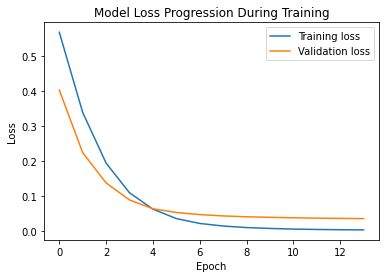

In [ ]:
plt.plot(epochs_info.history['loss'])
plt.plot(epochs_info.history['val_loss'])
plt.title("Model Loss Progression During Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Training loss", "Validation loss"])
plt.show()

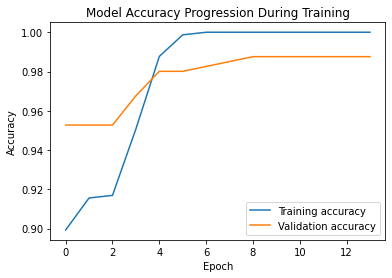

In [ ]:
plt.plot(epochs_info.history['accuracy'])
plt.plot(epochs_info.history['val_accuracy'])
plt.title("Model Accuracy Progression During Training")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Training accuracy", "Validation accuracy"])
plt.show()

## Model Evaluation

After taking the predictions from our model, we use the 0.5 threshold to separate the two classes. If an instance has more than 0.5 probability of belonging to class 1, its predicted label is 1; else, its predicted label is 0.

The confusion matrix obtained by our model is a very good one with only 5 false positives and 0 false negatives among 473 test instances. Measured accuracy is:

(41 + 427) / (41 + 5 + 0 + 427) = 0.989

Remaining metrics (recommended for imbalanced classes) confirm the near perfect performance of our model. Area under the Precision-Recall curve is 0.998; area under the ROC curve is 0.991.

In [ ]:
y_pred = nlp_nn_model.predict(X_test)
y_pred_classes = (y_pred > 0.5)

cm = confusion_matrix(y_test, y_pred_classes)
print("Model prediction confusion matrix:")
print(cm)

print("Area under the ROC curve:", roc_auc_score(y_test, y_pred))
print("Area under the PR curve:", average_precision_score(y_test, y_pred))

15/15 [==============================] - 0s 3ms/step
Model prediction confusion matrix:
[[ 41   5]
 [  0 427]]
Area under the ROC curve: 0.9918541900010183
Area under the PR curve: 0.9989976034811603


In [ ]:
X = alexa_df.iloc[:, :-6].values
y = alexa_df.iloc[:, -1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15,
                                                    random_state=42)

In [ ]:
nlp_nn_model_no_rating = tf.keras.models.Sequential()
nlp_nn_model_no_rating.add(tf.keras.layers.Dense(units=10, activation='relu',
                                       input_shape=(X_train.shape[1],)))
nlp_nn_model_no_rating.add(tf.keras.layers.Dropout(0.3))
nlp_nn_model_no_rating.add(tf.keras.layers.Dense(units=5, activation='relu'))
nlp_nn_model_no_rating.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

nlp_nn_model_no_rating.summary()

Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_132 (Dense)           (None, 10)                38010     
                                                                 
 dropout_29 (Dropout)        (None, 10)                0         
                                                                 
 dense_133 (Dense)           (None, 5)                 55        
                                                                 
 dense_134 (Dense)           (None, 1)                 6         
                                                                 
Total params: 38,071
Trainable params: 38,071
Non-trainable params: 0
_________________________________________________________________


In [ ]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', patience=10
)

# 20 batches are used in a data-driven approach.
batch_size = X_train.shape[0] // 20

# Learning rate larger than 0.001 leads to underfitting.
nlp_nn_model_no_rating.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy', metrics=['accuracy']
)

# 100 epochs are enough to let the early stopping callback work.
epochs_info = nlp_nn_model_no_rating.fit(X_train,
                                         y_train,
                                         batch_size=batch_size,
                                         epochs=100,
                                         validation_split=0.15,
                                         callbacks=[early_stopping_callback])

Epoch 1/100
18/18 [==============================] - 1s 19ms/step - loss: 0.6671 - accuracy: 0.7578 - val_loss: 0.6135 - val_accuracy: 0.9502
Epoch 2/100
18/18 [==============================] - 0s 9ms/step - loss: 0.5884 - accuracy: 0.9152 - val_loss: 0.5241 - val_accuracy: 0.9527
Epoch 3/100
18/18 [==============================] - 0s 10ms/step - loss: 0.5128 - accuracy: 0.9160 - val_loss: 0.4483 - val_accuracy: 0.9527
Epoch 4/100
18/18 [==============================] - 0s 9ms/step - loss: 0.4546 - accuracy: 0.9156 - val_loss: 0.3902 - val_accuracy: 0.9527
Epoch 5/100
18/18 [==============================] - 0s 9ms/step - loss: 0.3999 - accuracy: 0.9174 - val_loss: 0.3441 - val_accuracy: 0.9527
Epoch 6/100
18/18 [==============================] - 0s 9ms/step - loss: 0.3500 - accuracy: 0.9169 - val_loss: 0.3015 - val_accuracy: 0.9527
Epoch 7/100
18/18 [==============================] - 0s 10ms/step - loss: 0.3129 - accuracy: 0.9174 - val_loss: 0.2647 - val_accuracy: 0.9527
Epoch 8/10

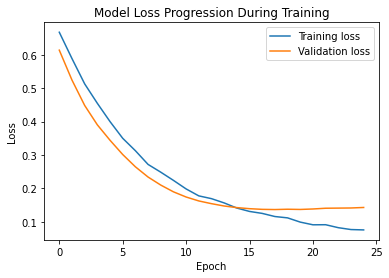

In [ ]:
plt.plot(epochs_info.history['loss'])
plt.plot(epochs_info.history['val_loss'])
plt.title("Model Loss Progression During Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Training loss", "Validation loss"])
plt.show()

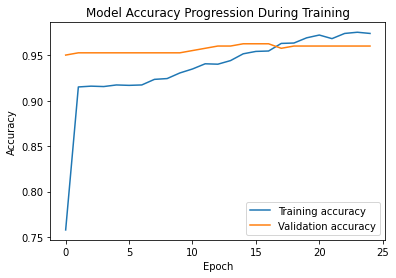

In [ ]:
plt.plot(epochs_info.history['accuracy'])
plt.plot(epochs_info.history['val_accuracy'])
plt.title("Model Accuracy Progression During Training")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Training accuracy", "Validation accuracy"])
plt.show()

In [ ]:
y_pred = nlp_nn_model_no_rating.predict(X_test)
y_pred_classes = (y_pred > 0.5)

cm = confusion_matrix(y_test, y_pred_classes)
print("Model prediction confusion matrix:")
print(cm)

print("Area under the ROC curve:", roc_auc_score(y_test, y_pred))
print("Area under the PR curve:", average_precision_score(y_test, y_pred))

15/15 [==============================] - 0s 4ms/step
Model prediction confusion matrix:
[[ 18  28]
 [  1 426]]
Area under the ROC curve: 0.8706088992974238
Area under the PR curve: 0.9768389051246342
